![plants_python_logo.jpg](../../images/plants_python_logo.jpg)

# 10.0 A short introduction to short read analysis

Now that we have assembled a genome and have some idea of its content, we can use it as a foundation to quantify biological information. We can get _billions_ of sequences from a single Illumina sequencing run, and we can use these sequences to gain insights into biological processes. We can align reads to a reference genome and identify base pair differences between different plants or cultivars. We can align sequenced mRNAs to gene models or a genome to measure gene expression (RNAseq). We can also look at epigenetic changes such as methylation (bisultife-seq), chromatin modifications (ChIPseq), or chromatin accessibility and conformation (ATACseq, HiC). There are many different ‘-seqs’, and maybe someday you can create _your own_ '-seq' to measure increasingly complex things. At the base of analyzing all of these datasets is aligning the raw data to a reference genome. We can do this the ‘old fashioned’ way (circa 2010) where we align the reads with base pair precision to the genome and store this information, or we can quasi or pseduo align and record _roughly_ where the read maps to. There are pros and cons to both approaches, which we will discuss below. 
Today we will go over how to access short read Illumina data, how to align/map RNAseq data, and a basic way to assess sample distribution and sample quality using a principle component analysis. We will continue this analysis in the next class where you will run alignment on a large dataset and we will run differential gene expression and network co-expression analyses. Here, we will use one set of tools that run comparatively quickly, but we will use a slightly different, though conceptually similar pipeline in the next activity. 

The basic principle of RNA sequencing (RNAseq) analysis is to use the number of reads that align to different genes in the genome as a proxy of how much those genes are expressed. RNAseq libraries are made from random messenger RNAs, so the pool of sequences is a good representation of what's being expressed in a given tissue at a particular timepoint. There are different types of RNAseq libraries, but here we will focus on the most common approach where mRNA is enriched using poly T beads, reverse transcribed into DNA, framgented, and ligated to adapters for sequencing. A gene that is highly expressed will be represented many times in the pool of randomly sampled mRNAs. If we look at the alignmnet of RNAseq reads to a highly expressed gene, we can see many reads are aligning (see below). A gene that has low expression will have comparably few reads aligning to it. This is the foundational concept of RNAseq analysis and we can survey gene expression on a genome-wide level by counting how many reads are aligning to each gene model.
![hi_low_gene_expression.png](../../images/hi_low_gene_expression.png)

## Plant Biology Learning Objectives:

- Understand the principles of gene expression analyses and RNAseq
- Explain the fundamentals of Illumina data generation and analysis
- Understand the distinction between mapping and quasi-mapping Illumina data
- Introduce downstream analyses of gene expression data (differential expression and gene co-expression network analyses)
- Introduce the frontiers of gene expression analyses (single cell RNAseq)


## Python Learning Objectives:

- Understand the principles of dimensionality reduction including feature selection and feature extraction
- Learn how to filter, subset, and transform pandas dataframes
- Learn how to use scikit-learn to perform principal component analysis


# 10.1 Introduction to gene expression (RNAseq) analysis
<br>
In this lesson, we will learn about different read alignment and quantification programs, analyze gene expression data from maize, interpret the outputs, and run some quality control analyses on a matrix of RNAseq expression values. In the activity, we will run an RNAseq analysis on data downloaded from the SRA. This is simply a starting point for RNAseq, and there are numerous downstream analyses that can be run to identify genes that are differentially expressed between any two samples/conditions/timepoints, construct gene co-expression networks, compare expression between species, and identify genes or pathways that are important for a given biological process. Below is a broad introduction to RNAseq analysis: 

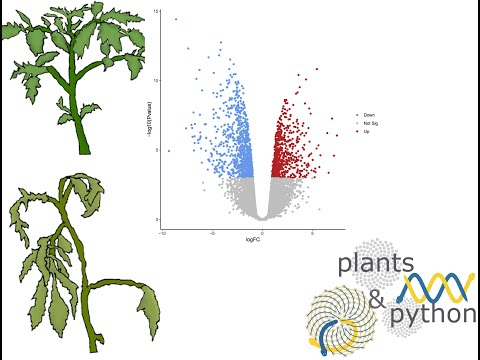

In [1]:
from IPython.display import YouTubeVideo

YouTubeVideo("Os5BuF4T6T4",width=960,height=540)

# Downloading data from the NCBI Sequence Read Archive (SRA)

![ncbi1.jpeg](../../images/ncbi1.jpeg)
<br>
The National Center for Biotechnology Information (NCBI) maintains a massive repository, the Sequence Read Archive (SRA) for next generation and third generation sequencing data: <br>
https://www.ncbi.nlm.nih.gov/sra <br>
The SRA has petabytes ( >1,000,000,000,000,000 base pairs) of raw data from many living and some extinct species on Earth.  You can search for your favorite species in the search bar at the top and see if there are any sequences available. Some of the SRA data has been extensively mined, but most of it has only been analyzed _superficially_. There are over 30,000 RNAseq samples for Arabidopsis and ~16,000 for maize on the SRA from all kinds of tissues, stresses, developmental time points, etc. Some of this data is defintley low quality, but most was probably carefully collected. What additional insights could be gained by analyzing ALL THE DATA using a common framework? What can be discovered from reanalyzing comparable datasets from many species at once? The SRA is a rich treasure trove of data, and it's free to use. Most journals require that sequencing data must be deposited in a public repository like the SRA, so keep this in mind. We can download data from the SRA directly to hpcc. <br> <br>
**First,** search the sra database for your favorite species. You can try the common name, but you will probably only find data using its scientific name. <br>
If click on an entry from your search, you will see something like this: 
![ncbi2.jpeg](../../images/ncbi2.jpeg)
There is a lot of information here, but I have highlighted a few key details. This sample is RNAseq from the orphan grain crop tef under watterlogging (flooding) conditions. It also lists who collected the data, the sequencing technology, and whether the data is single or paired end (as discussed below). At the bottom, I have highlighted a number beginning with `SRR`. This is the unique sequence read identifier for this sample, and we can download data using this identifier.<br>
Run a search for your favorite species and answer a few questions. Record the SRA number, and we will download this data.

In [ ]:
## What species did you choose? 


## How many samples are there for your species? 


## For one entry, provide the SRR identifier, the type of data, and the tissue it was collected from. 

What is the format for short read sequencing data? We are familiar with the .fasta format of sequence data, and short read Illumina data has a similar format that builds in quality scores. 
<br>
Most Illumina data you will encounter is stored in a .fastq format as shown below: <br>

    @SRR1620941.1 AMELIA:320:C2J1FACXX:3:1101:1504:2233 length=202
    CTGGGATGTTTGGGCGGCTTCAGATCTGTGGAGTTCGACTCCCTGCATGAGCACCCGGGCTCCTCGCTTGAGAGGCGATC
    GTGGTCGCTCACAGCCTCGCCCGACGCCTCCGCTGCCGAGGGATGGGTGGACGAGCTCCGGCGGCTGCGCGTCGCCGAGC
    TCCGTCGCGACGTCGAGCGATGCGATCTCTCTATCGGGACGC
    +SRR1620941.1 AMELIA:320:C2J1FACXX:3:1101:1504:2233 length=202
    B@@FFDDFHHHFHJJJJJJJJJJIJJJIJJJJJHHGIGGIIIJHHHHHFFFFFEDDDDCDDDDCDDDDDDBCDDD@<9@D
    BCBDDDDBDDDDDCBBCDBD<+=BDFFFFHHHHHJJJJIJJIGGHJJGIJIJJGJHFEHFFCDDDDDDD8BDDBDDDBBB
    DCCDABDDDDDDBDD@BBB>ABDDBDD@CDCCCCCBBD<BB>
    @SRR1620941.2 AMELIA:320:C2J1FACXX:3:1101:2085:2106 length=202
    CCTGCTTCGCTGCCTGGACTGCCAGCGCCGCTGCTTCCTCTGCAGCCTTCAGGCGTGCAGCCCGGCTGGGGAAGTCGCCC
    AGCTCTCCTTCGCTGGTTCCCCTTCCCTACACATGTCGACCTCTGCTGAGCGCGCTGCCAGGCTCAAGGCCAAGGGAACC
    AGCGAAGGAGAGCTGGGCGACTTCCCCAGCCGGGCTGCACGC
    +SRR1620941.2 AMELIA:320:C2J1FACXX:3:1101:2085:2106 length=202
    CCCFFFFFHHHHHIGIJGIIJJJJJJJJGIJJJIIJHJJJJJJJJIBGIEA?EADFDDDDEDBDBBDDDDDDDDCC@5?@
    BB?CCDDDCCDBDDD>A@CC@+=BFFFFFHHHHHJJJJIJJIJJIIJJJJJIIIIIJIIJIJIIJIEHIJHHHHFFFFDD
    CDDDDDDDBDBDDDDDDDD9BBDDADDDBDBBBBDDDDDDDD
 <br>
1. The first line (starting with @SRR...) is a unique identifier for that read. Remember, experiments can have billions of reads, so the names/identifiers can be quite long. <br>
2. The second line (starting with ATG...) is the actual sequence. This is the bit we care most about. <br>
3. The third line (starting with +SRR...) is the same unique identifier for that read. <br>
4. The fourth line (seemingly random characters) contains the quality scores. Each letter, symbol, or number corresponds to a sequence position. The sequences and quality scores will always have the same number of characters. During sequencing, the Illumina machine will asign a quality score for each base pair based on how confident the base call was. Some clusters that are close together can have mixed signals and as the Illiumina run progresses, reagents wear down and quality scores tend to be lower. We can use these quality scores to remove 'bad' bases and during read alignment. 

# Challenge problem: Download SRA data onto HPCC:
<br>
Lets say you want to reanalyze this data or combine data from several experiments. We can use the SRA-Toolkit program to download data from the SRA. The SRA toolkit is installed on HPCC and can be accessed by loading the module from a **developmental node** or in a SLURM submission script. Simply type: <br> <br>

`$ module load SRA-Toolkit/2.10.7-centos_linux64`

<br> <br>
We can then download the data using the following command: <br> <br>
`$ fastq-dump SRR1620942` <br>
<br>
**Note:** I have included an example SRR number here, but you should download the file you described above for your favorite species! Also, you need to specify the output directory (`--outdir <path>`) or the reads will be downloaded by default into your present working directory. The SRR number can be found at the bottom left hand corner of the info page for that sample. 
<br>
<br>
Because fastq files can get quite large, raw sequences should be downloaded into scratch (`/mnt/scratch/MSU_ID/`) or your home directory (`/home/MSU_ID`). Remember, files on scratch are deleted automatically after 45 days, so don't leave anything important there! I have also downloaded some test data into the course directory 
<br>
Some data is single end and some will be paired end. Single end reads are just sequenced in one direction where paired end data is sequenced in both directions where one read corresponds to one end of a sequenced fragment and its pair corresponds to the other end. If the data is paired end, you can split it into Read 1 and Read 2 by using the split flag as follows: <br> <br>
`$ fastq-dump --split-3 SRR1620942` <br> <br>
It is also useful to rename the files from the default SRR number into something more informative (i.e. species name, tissue type, sample, treatment, etc). 

This approach is fine when downloading a few files, but what if we want to download _a lot_ of .fastq files? We could recursively run each sample one at a time, but that would take ages and be a poor use of our time. Instead, we can write a simple shell script and list to download a batch of files as follows. Note, shell script is another programming language with different rules or syntax compared to Python. For our purposes, we will only need to know a few simple functions such as loops, and here is a nice tutorial on the basics of shell programming: https://www.shellscript.sh/. Below is an example script we can use to download sequencing data in bulk: <br>
    
    #!/usr/bin/bash
    fastq-dump $1
<br>
Where $1 sets the first argument in command line.  
<br>
Then, we can create a list of SRA identifiers for the files we want to download with one identifier per line as follows: <br>

    SRR1620941
    SRR940286
    SRR940284
    SRR940283
    SRR940276
    SRR940278
    SRR940279
    SRR1620975
    SRR1620976
    SRR1620977
<br>
We can then read this list and feed it into our shell script to download the files recursively `|` connects the 
    $cat list_SRA.txt | xargs -n 1 bash get_SRR_data.sh

# 10.2 Dimensionality reduction

<br>
Large-scale datasets are difficult to interpret 'by eye'. We can graph simple metrics such as leaf number, photosynthetic rate, number of caterpillars on a plant, etc. and run a simple statistical test to see if two samples differ from expectatiobs. With gene expression analyses, we have a data matrix with tens of thousands of genes across any number of samples or experimental conditions. How can we simplify this dataset so it can be easily visualized or used in downstream analyses such as predictive modeling or machine learning? <br>
Dimensionality reduction is an approach to transform complex, high dimensionality data (such as an RNAseq matrix) into a low dimensional space that still captures the biologically meaningful patterns of the experiment. We could use principle component analysis (PCA) to transform a large expression matrix into two or three meaningful principle components to see the relation of samples over the experimental space. The following video introduces the concept of dimensionality reduction and how to run a PCA on an expression matrix using the powerful python package `scikit-learn`.

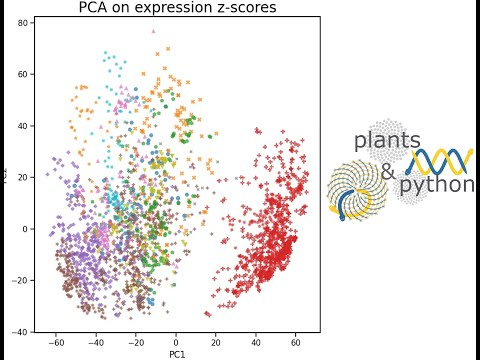

In [1]:
from IPython.display import YouTubeVideo

YouTubeVideo("Rq4ZoDutfqU",width=960,height=540)

In [3]:
# Import modules

import numpy as np
import pandas as pd

# Load the test dataset
expr_df = pd.read_csv('Lesson10_tef_raw_TPM.txt')
expr_df = expr_df.set_index(expr_df.columns[0])
expr_df.head()
expr_df.shape

,M1_seed_R1,M1_seed_R2,M1_seed_R3,M2_seed_R1,M2_seed_R2,M2_seed_R3,M3_seed_R1,Leaf_R1,Leaf_R2,Leaf_R3,...,Seedling_shoot_R3,WW_4pm_R1,WW_4pm_R2,WW_4pm_R3,D1_4pm_R1,D1_4pm_R2,D1_4pm_R3,D2_4pm_R1,D2_4pm_R2,D2_4pm_R3
Gene,,,,,,,,,,,,,,,,,,,,,
Et_1A_005362,437.490463,390.069806,482.929434,460.658347,294.813733,1102.322170,122.646504,536.061082,476.459196,737.337357,...,359.190124,664.892941,925.286936,225.699840,1052.120267,835.028853,1049.412538,340.910330,604.088544,1049.854609
Et_1A_005363,38.819070,47.975194,86.539536,56.274102,38.821990,100.188915,61.913293,86.650052,78.437334,92.341553,...,191.634394,244.138118,385.831233,27.365897,242.757066,356.816486,407.591321,276.874058,237.531075,516.873087
Et_1A_005358,23.903977,17.551828,47.075660,21.166322,20.158580,58.435345,5.351263,2.999328,0.999514,0.960335,...,76.323273,3.683663,5.486084,0.991862,0.000000,0.969208,0.000000,0.000000,0.000000,0.000000
Et_1A_005364,16.035041,65.453597,158.341059,115.392086,7.406192,59.320112,3.522129,0.970219,2.978374,2.888564,...,63.576770,3.833652,18.974145,1.034732,4.370649,10.930585,8.091588,6.468440,2.958588,6.059157
Et_1A_005360,375.898883,575.577191,622.265206,842.204448,148.923493,540.147349,9.030574,364.468055,299.525491,695.661527,...,1579.727213,1607.665707,2969.700298,514.597388,170.898261,388.114632,687.474062,27.872893,61.503745,113.573922
